# Real-Time Facial Emotion Detection

<img = expressions.jpg>

## Introduction

In [1]:
#Import the necessary packages
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import cv2
import os, shutil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Dhruv Patel\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Parameters

num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 100

In [3]:
#GPU Configuration

config = tf.ConfigProto( device_count = {'GPU': 1} ) #Allow TensorFlow to use your GPU, GPU = 0 will only make use of the CPU
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [4]:


with open("data/fer2013/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


In [5]:
#Initialize train, test and validation set

x_train, y_train, x_test, y_test, x_val, y_val = [], [], [], [], [], []

In [6]:
#Transfer data into these sets

for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
        elif 'PrivateTest' in usage:
            y_val.append(emotion)
            x_val.append(pixels)
    except:
        print("",end="")

In [7]:
#Data transformation for train, test and validation sets

x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')
x_val = np.array(x_val, 'float32')
y_val = np.array(y_val, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_val /= 255
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_val = x_val.reshape(x_val.shape[0], 48, 48, 1)
x_val = x_val.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

#Count the number of samples in each set

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_val.shape[0], 'validaiton samples')

28709 train samples
3589 test samples
3589 validaiton samples


In [8]:
#Building the network

model = Sequential()

#1st Convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

#2nd Convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

#3rd Convolution layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

#Fully Connected Layers

model.add(Dense(1024))#, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1024))#, activation='relu'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
__________

In [9]:
#Data Augmentation and Batch Process


gen = ImageDataGenerator(
      rotation_range = 45,
      width_shift_range = 0.2,
      height_shift_range = 0.2,
      shear_range = 0.2,
      zoom_range = 0.2,
      horizontal_flip=True,
      fill_mode = 'nearest')


train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

In [10]:
#The compilation step

model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam(lr = 0.0001)
    , metrics=['accuracy'])

In [11]:
#Fit the model

history = model.fit_generator(train_generator, 
                              validation_data = (x_val, y_val), 
                              steps_per_epoch=batch_size, 
                              epochs=epochs)

Epoch 1/100
256/256 [==============================] - 134s 522ms/step - loss: 2.0390 - acc: 0.2227 - val_loss: 1.9117 - val_acc: 0.2198
Epoch 2/100
256/256 [==============================] - 127s 498ms/step - loss: 1.9234 - acc: 0.2386 - val_loss: 1.7568 - val_acc: 0.2797
Epoch 3/100
256/256 [==============================] - 141s 553ms/step - loss: 1.8564 - acc: 0.2616 - val_loss: 1.6871 - val_acc: 0.3185
Epoch 4/100
256/256 [==============================] - 143s 557ms/step - loss: 1.7985 - acc: 0.2835 - val_loss: 1.7872 - val_acc: 0.2850
Epoch 5/100
256/256 [==============================] - 141s 551ms/step - loss: 1.7383 - acc: 0.3091 - val_loss: 1.7946 - val_acc: 0.2979
Epoch 6/100
256/256 [==============================] - 140s 549ms/step - loss: 1.6816 - acc: 0.3373 - val_loss: 1.5304 - val_acc: 0.4009
Epoch 7/100
256/256 [==============================] - 140s 545ms/step - loss: 1.6343 - acc: 0.3604 - val_loss: 1.4788 - val_acc: 0.4227
Epoch 8/100
256/256 [====================

In [12]:
# Save the weights

model.save('fed_16.h5')

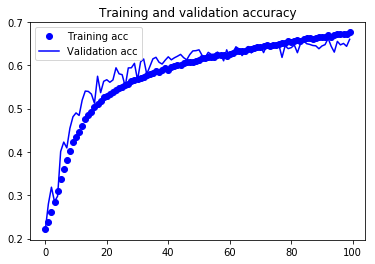

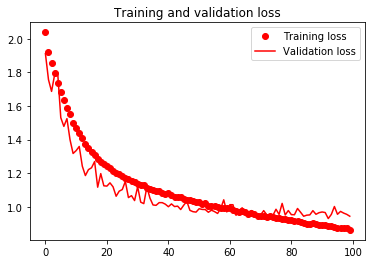

In [13]:
#Graph for training and validation accuracy

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

#Graph for training and validation loss

plt.plot(epochs, loss, 'bo', color = 'red', label='Training loss')
plt.plot(epochs, val_loss, 'b', color = 'red', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
#Evaluation on the test set

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

3589/3589 [==============================] - 2s 599us/step
Test loss: 1.0076111878615364
Test accuracy: 63.30454165837863


In [15]:
#function for drawing bar chart for emotion preditions

def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [16]:
monitor_testset_results = False

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
            #print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

C:\Users\Dhruv Patel\Anaconda3\lib\site-packages\keras_preprocessing\image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


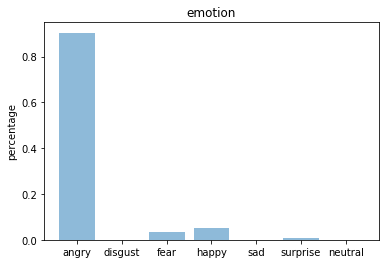

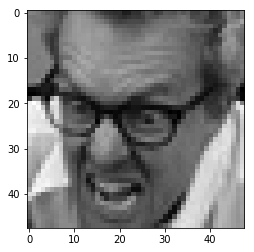

In [17]:
#make prediction for custom image out of test set

img = image.load_img("/data/fer2013/PublicTest/0/PublicTest_794846.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()

In [18]:
# choose any image to want by specifying the index
img_to_visualize = x_train[25]
# Keras requires the image to be in 4D
# So we add an extra dimension to it.
img_to_visualize = np.expand_dims(img_to_visualize, axis=0)

In [19]:
def layer_to_visualize(layer):
    inputs = [K.learning_phase()] + model.inputs

    _convout1_f = K.function(inputs, [layer.output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])

    convolutions = convout1_f(img_to_visualize)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[0]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(len(convolutions)):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[i], cmap='gray')

In [20]:
# Specify the layer to want to visualize
layer_to_visualize(conv2d_2)

# As convout2 is the result of a MaxPool2D layer
# We can see that the image has blurred since
# the resolution has reduced 
layer_to_visualize(conv2d_2)

NameError: name 'conv2d_2' is not defined

In [21]:
#load the weights of the model

from keras.models import load_model

model = load_model('fed_16.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 44, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 128)       512       
__________

In [22]:
img_path = '/data/fer2013/PrivateTest/0/PrivateTest_310384.jpg'

# We preprocess the image into a 4D tensor
from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(48, 48, 1))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.

# Its shape is (1, 150, 150, 3)
print(img_tensor.shape)

(1, 48, 48, 3)


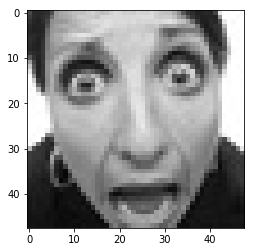

In [23]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [24]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:21]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [25]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(x_train[10].reshape(1,48,48,1))

In [26]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 44, 44, 64)


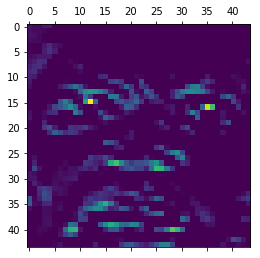

In [27]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 1], cmap='viridis')
plt.show()

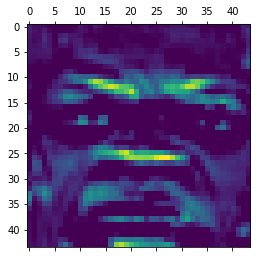

In [28]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

C:\Users\Dhruv Patel\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Dhruv Patel\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


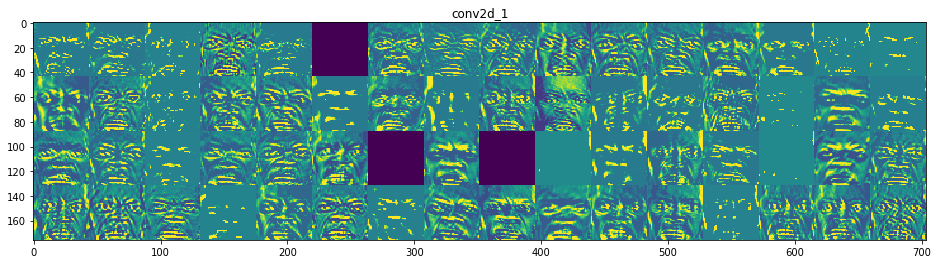

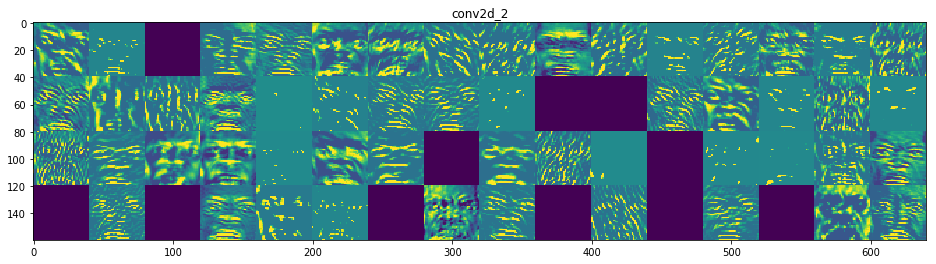

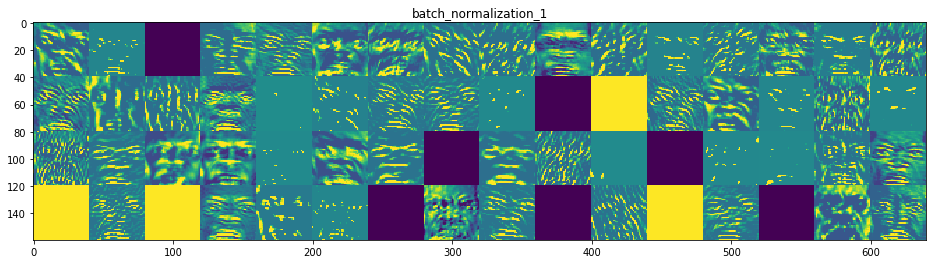

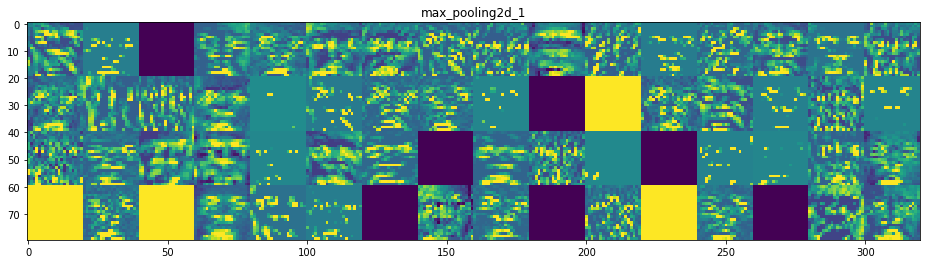

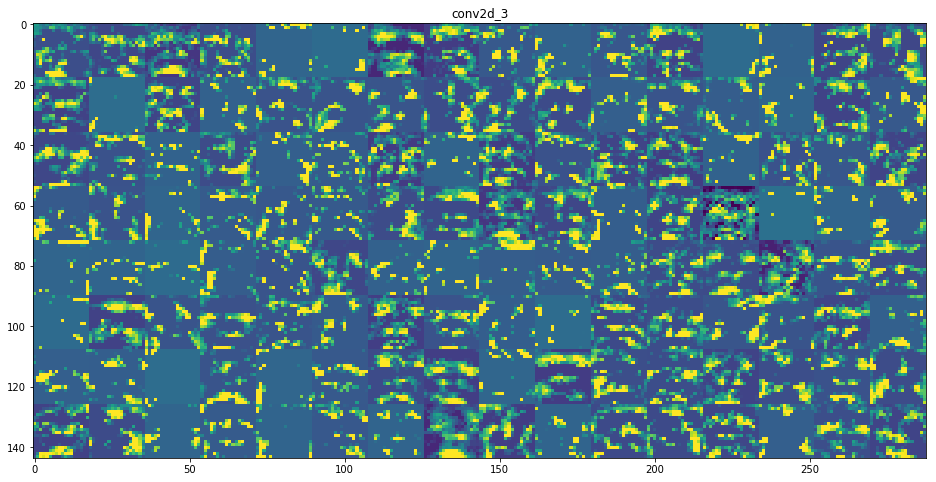

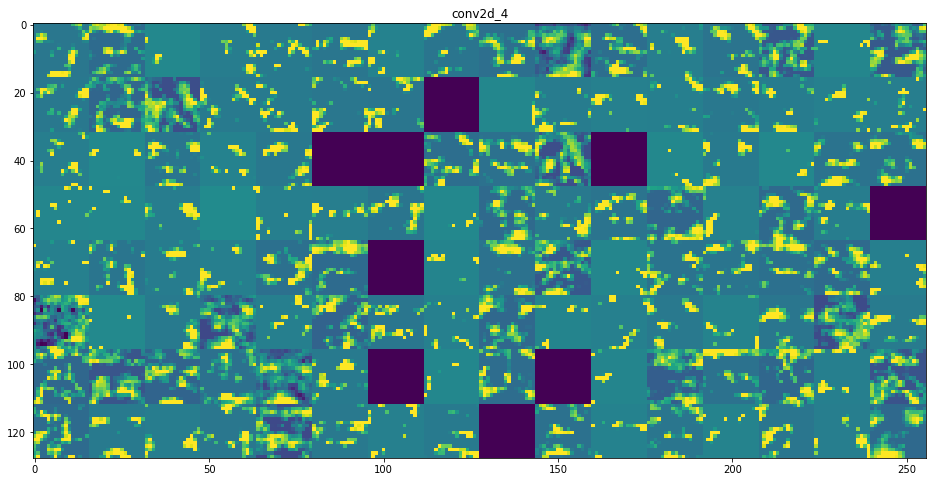

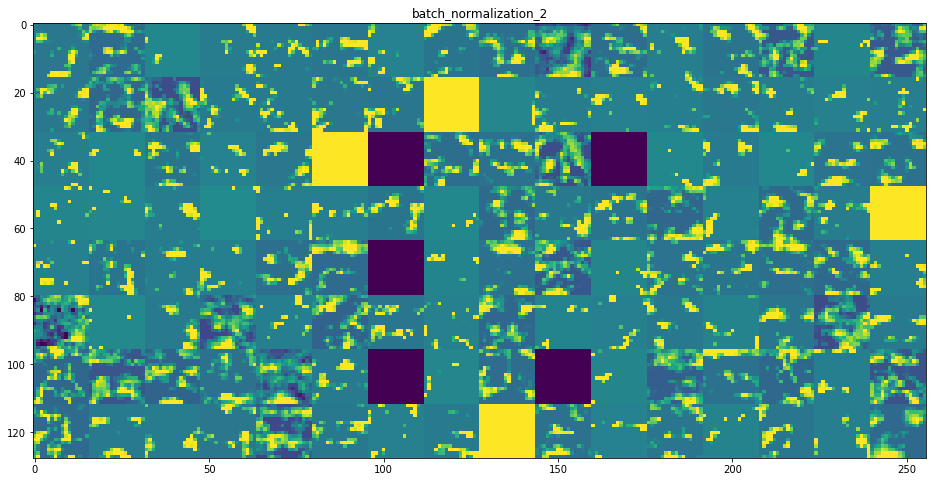

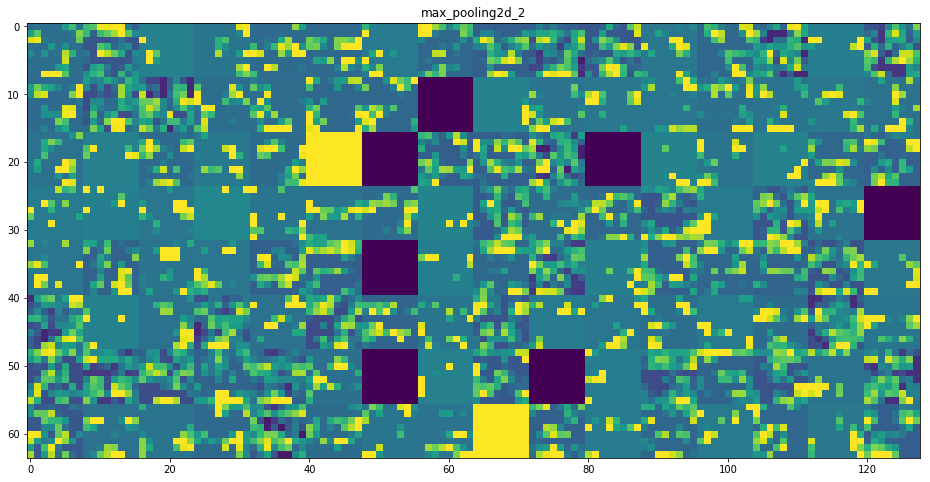

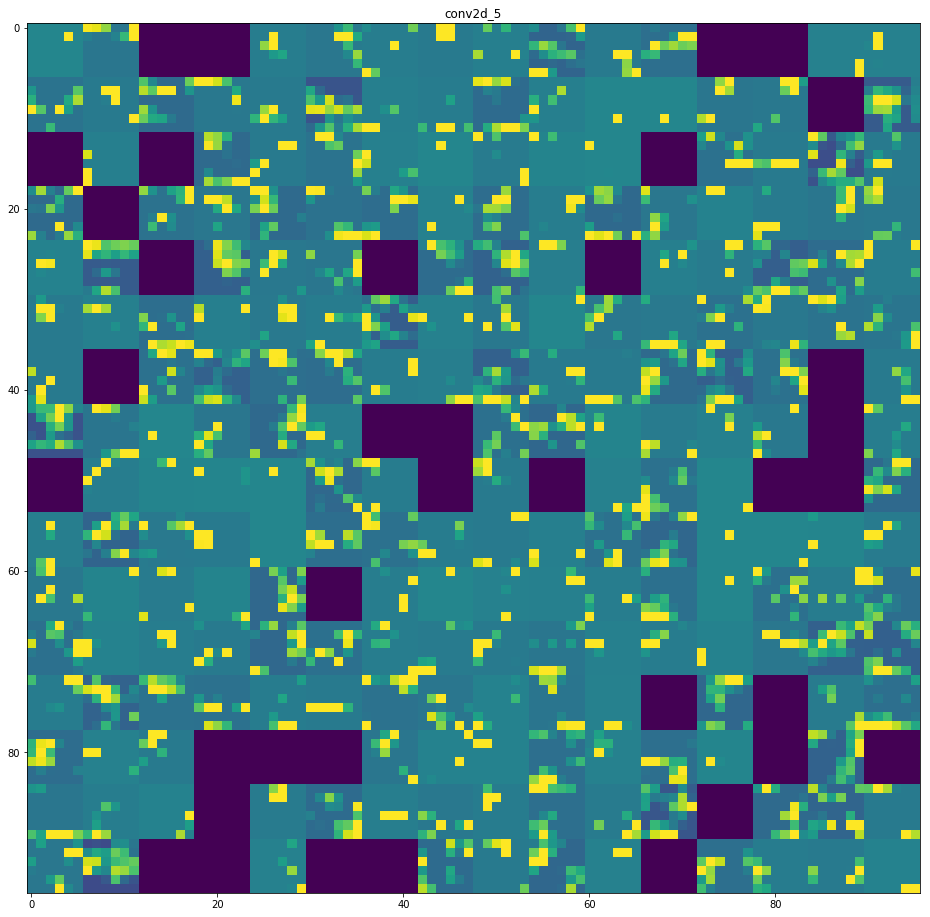

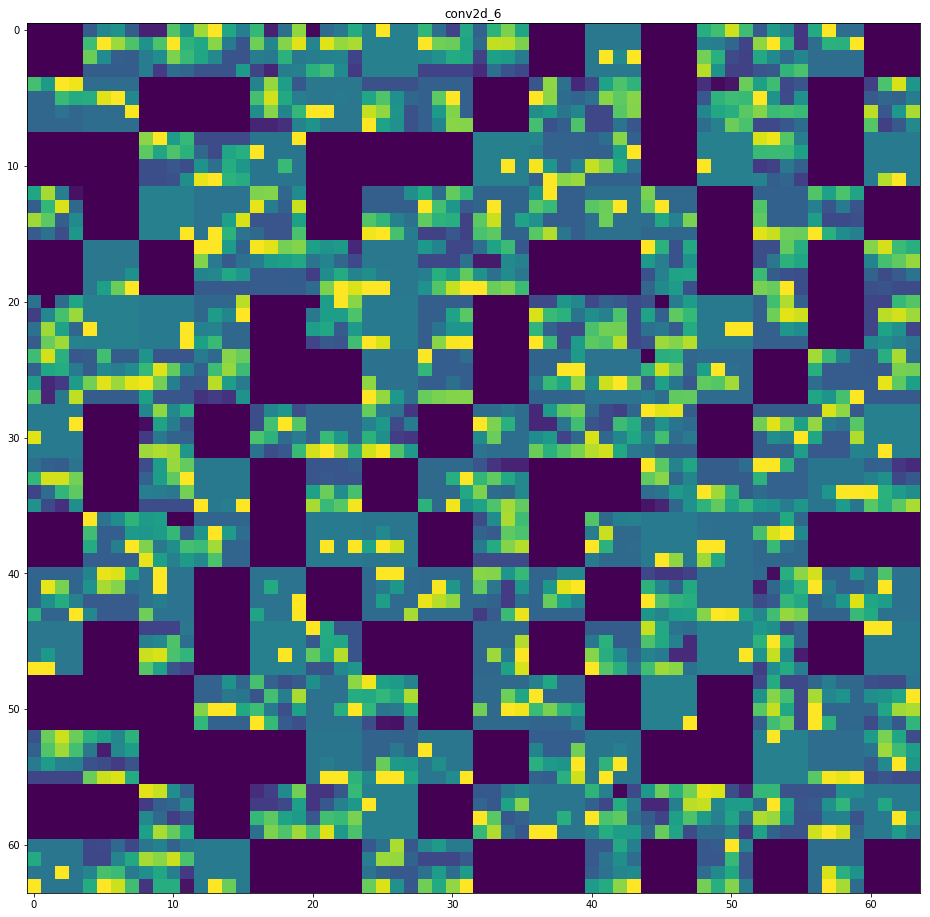

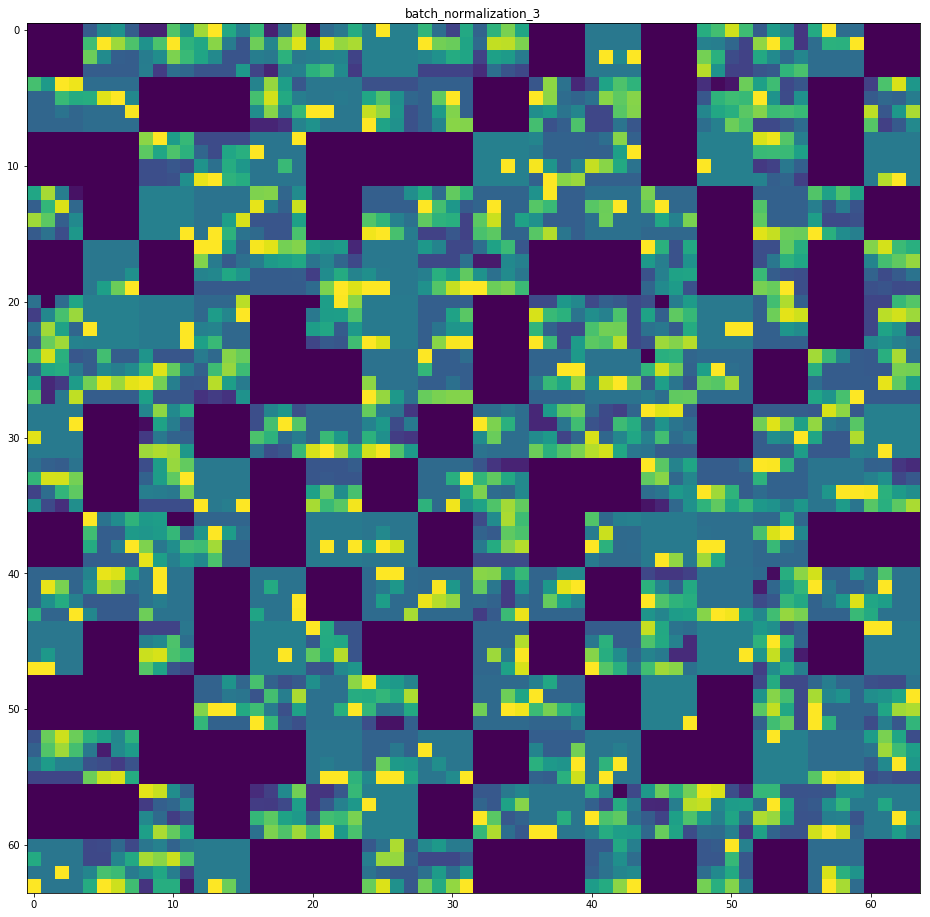

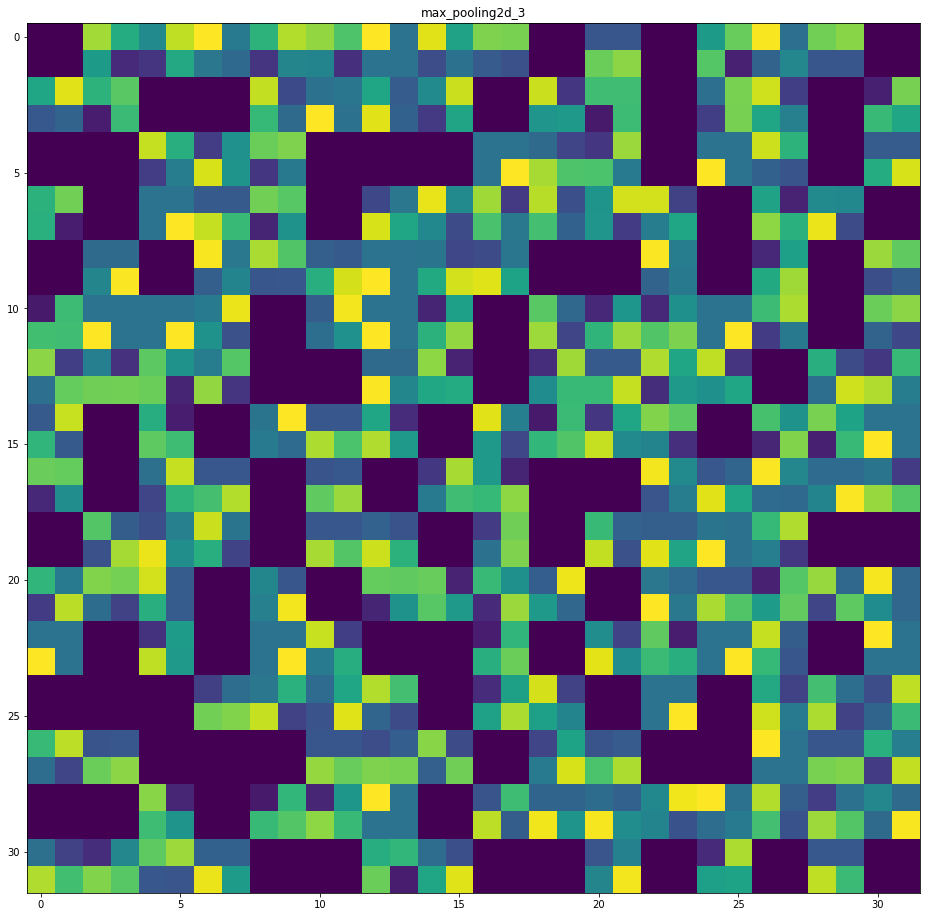

In [29]:

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [ ]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x_train[10].reshape(1,48,48,1))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='inferno')
            activation_index += 1
        

In [ ]:
plt.imshow(x_train[10][:,:,0]);

In [ ]:
display_activation(activations, 8, 8, 1)

In [ ]:
display_activation(activations, 8, 8, 3)

In [ ]:
display_activation(activations, 8, 8, 5)

In [30]:
from sklearn.metrics import confusion_matrix
Y_prediction = model.predict(x_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

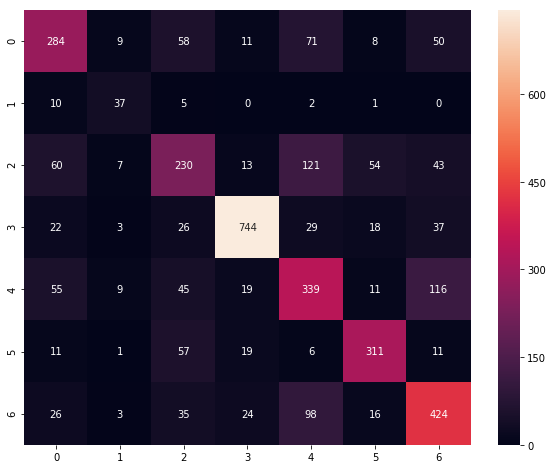

In [31]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [ ]:
#opencv initialization

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

In [ ]:
#face expression recognizer initialization
from keras.models import model_from_json
model = model_from_json(open("Facial Emotion Detection/facial_expression_model_structure.json", "r").read())
model.load_weights('facial_expression_model_weights.h5') #load weights

In [ ]:
emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

while(True):
    ret, img = cap.read()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    #print(faces) #locations of detected faces

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2) #draw rectangle to main image
        
        detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face
        detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY) #transform to gray scale
        detected_face = cv2.resize(detected_face, (48, 48)) #resize to 48x48
        
        img_pixels = image.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        
        img_pixels /= 255 #pixels are in scale of [0, 255]. normalize all pixels in scale of [0, 1]
        q
        predictions = model.predict(img_pixels) #store probabilities of 7 expressions
        
        #find max indexed array 0: angry, 1:disgust, 2:fear, 3:happy, 4:sad, 5:surprise, 6:neutral
        max_index = np.argmax(predictions[0])
        
        emotion = emotions[max_index]
        
        #write emotion text above rectangle
        cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        
        #process on detected face end
        #-------------------------
        cv2.imshow('img',img)

    if cv2.waitKey(1) & 0xFF == ord('q'): #press q to quit
        break

#kill open cv things
cap.release()
cv2.destroyAllWindows()

# MIT LICENSE: 

Copyright 2018 Jay Choksi, Prathamesh Tari, Dhruv Patel

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.